# Оптимищация маркетинговых затрат сервиса Яндекс.Афиша

### Задача: 
Сформировать рекомендации маркетологам по оптимизации маркетинговых затрат в сервисе Яндекс.Афиша

### План проекта:
1. Загрузить данные и подготовить их к анализу
2. Построить отчёты и посчитать метрики продукта
 1. Сколько людей пользуются в день, неделю, месяц
 2. Сколько сессий в день
 3. Сколько длится одна сессия
 4. Как часто люди возвращаются
3. Построить отчёты и посчитать метрики продаж
 1. Когда люди начинают покупать
 2. Сколько раз покупают за период
 3. Какой средний чек
 4. Сколько денег приносят (LTV)
4. Построить отчёты и посчитать метрики маркетинга
 1. Сколько денег потратили
 2. Сколько стоило привлечение одного покупателя из каждого источника
 3. На сколько окупились расходы (ROI)
5. Вывод

In [1]:
#Импортируем бибилиотеки 
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns
from matplotlib import pyplot as plt

## Загрузка данных и подготовка их к анализу

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [3]:
display(visits.info())
print(visits.isna().sum())
display(visits.head(10))
display(visits[visits['End Ts'] < visits['Start Ts']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


,Device,End Ts,Source Id,Start Ts,Uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Данные таблицы visits:
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [4]:
display(orders.info())
print(orders.isna().sum())
display(orders.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

Buy Ts     0
Revenue    0
Uid        0
dtype: int64


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Данные таблицы orders:
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

In [5]:
display(costs.info())
print(costs.isna().sum())
display(costs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

source_id    0
dt           0
costs        0
dtype: int64


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Данные таблицы costs:
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Предобработка данных

In [6]:
#Приведём название столбцов в один формат с другими таблицами
visits.rename(columns={'End Ts': 'end_ts', 'Device':'device', 'Start Ts': 'start_ts', 'Source Id':'source_id','Uid':'uid'}, inplace=True)
orders.rename(columns={'Buy Ts': 'buy_ts','Revenue':'revenue','Uid':'uid'}, inplace=True)

In [7]:
#Приведём в порядок даты 
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y.%m.%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y.%m.%d %H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y.%m.%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y.%m.%d')

#Уберём пару аномальных значений, где дата старта сессии позже, чем конец сессии. 
visits = visits[visits['start_ts'] < visits['end_ts']]

## Отчёты и метрики по продуктам 

Определим сколько людей пользуется сервисом Яндекс.Афиши ежедневно/еженедельно/ежемесячно 

<ipython-input-8-3eef5311219e>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['session_week'] = visits['start_ts'].dt.week


В среднем в день сервисом пользуется людей:  817


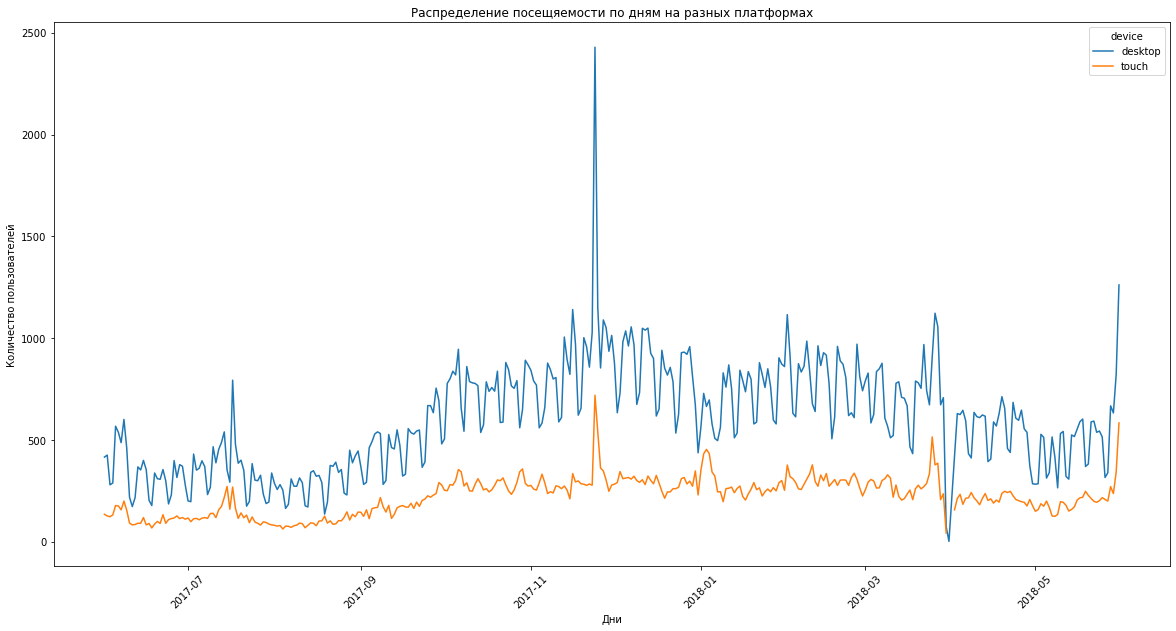

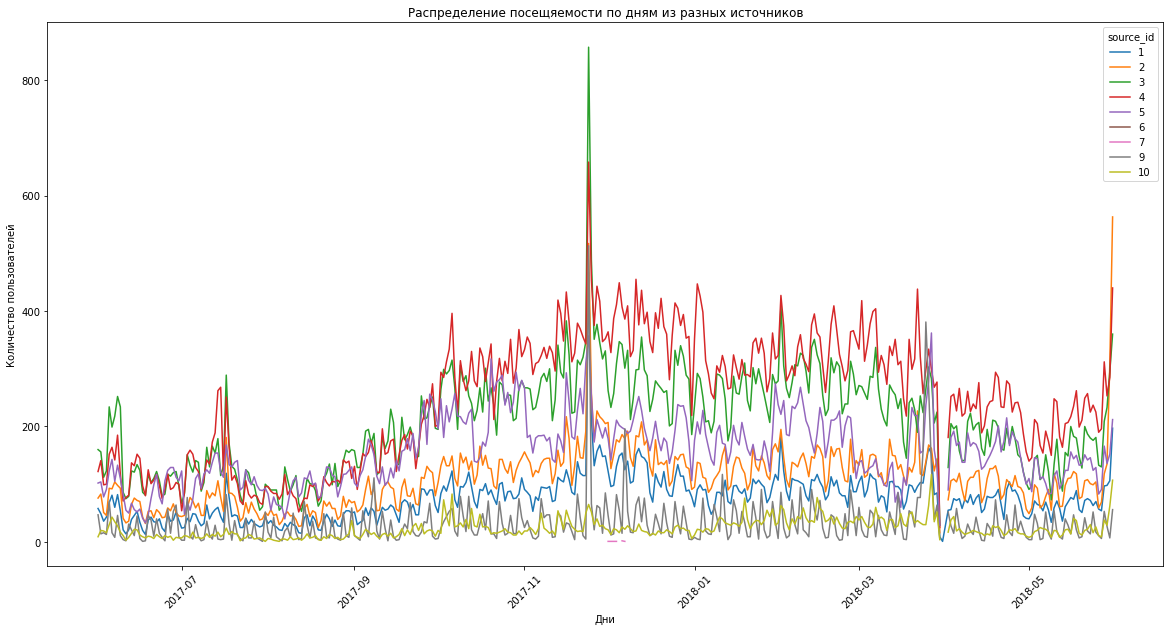

In [8]:
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

#Посчитаем и визуализируем сколько пользователей пользуется Яндекс.Афишей ежедневно. Метрика - DAU
dau_total = visits.groupby(['session_date']).agg({'uid': 'nunique'}).mean().astype('int')
print('В среднем в день сервисом пользуется людей: ', dau_total['uid'])
visits.pivot_table(index='session_date', columns='device', values='uid', aggfunc='nunique').plot(figsize=(20,10))
plt.xlabel("Дни")
plt.ylabel("Количество пользователей")
plt.xticks(rotation= 45)
plt.title('Распределение посещяемости по дням на разных платформах')
plt.show()
visits.pivot_table(index='session_date', columns='source_id', values='uid', aggfunc='nunique').plot(figsize=(20,10))
plt.xticks(rotation= 45)
plt.xlabel("Дни")
plt.ylabel("Количество пользователей")
plt.title('Распределение посещяемости по дням из разных источников')
plt.show()

В среднем в неделю сервисом пользуется людей:  5148


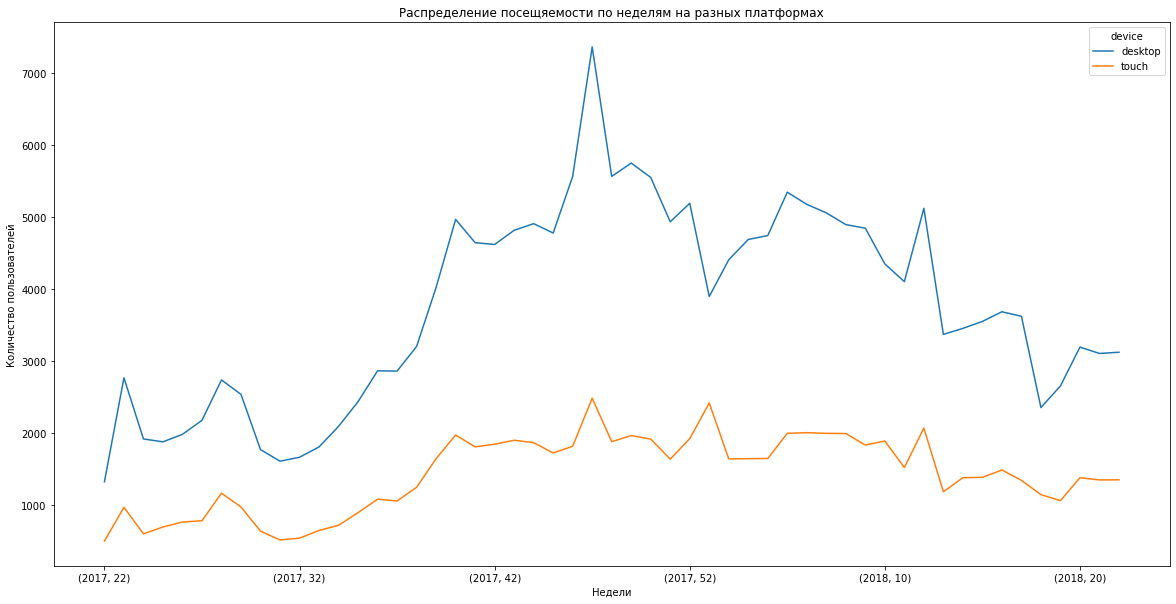

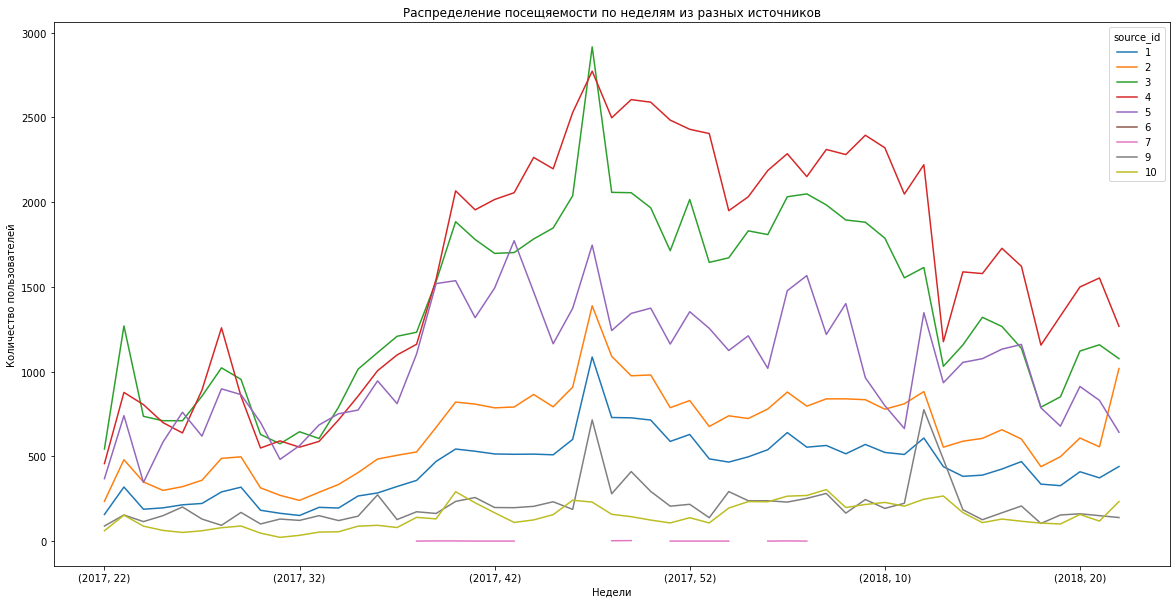

In [9]:
#Посчитаем сколько пользователей пользуется Яндекс.Афишей еженедельно. Метрика - WAU
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean().astype('int')
print('В среднем в неделю сервисом пользуется людей: ', wau_total['uid'])
visits.pivot_table(index=['session_year', 'session_week'], columns='device', values='uid', aggfunc='nunique').plot(figsize=(20,10))
plt.title('Распределение посещяемости по неделям на разных платформах')
plt.xlabel("Недели")
plt.ylabel("Количество пользователей")
plt.show()
visits.pivot_table(index=['session_year', 'session_week'], columns='source_id', values='uid', aggfunc='nunique').plot(figsize=(20,10))
plt.title('Распределение посещяемости по неделям из разных источников')
plt.xlabel("Недели")
plt.ylabel("Количество пользователей")
plt.show()

В среднем в месяц сервисом пользуется людей:  20955


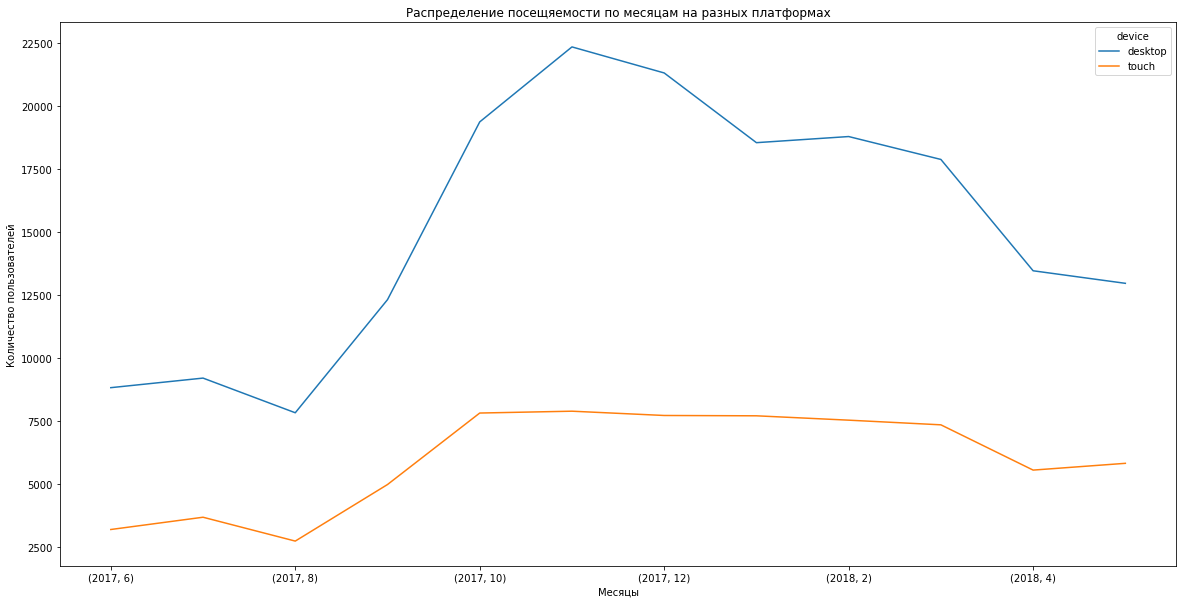

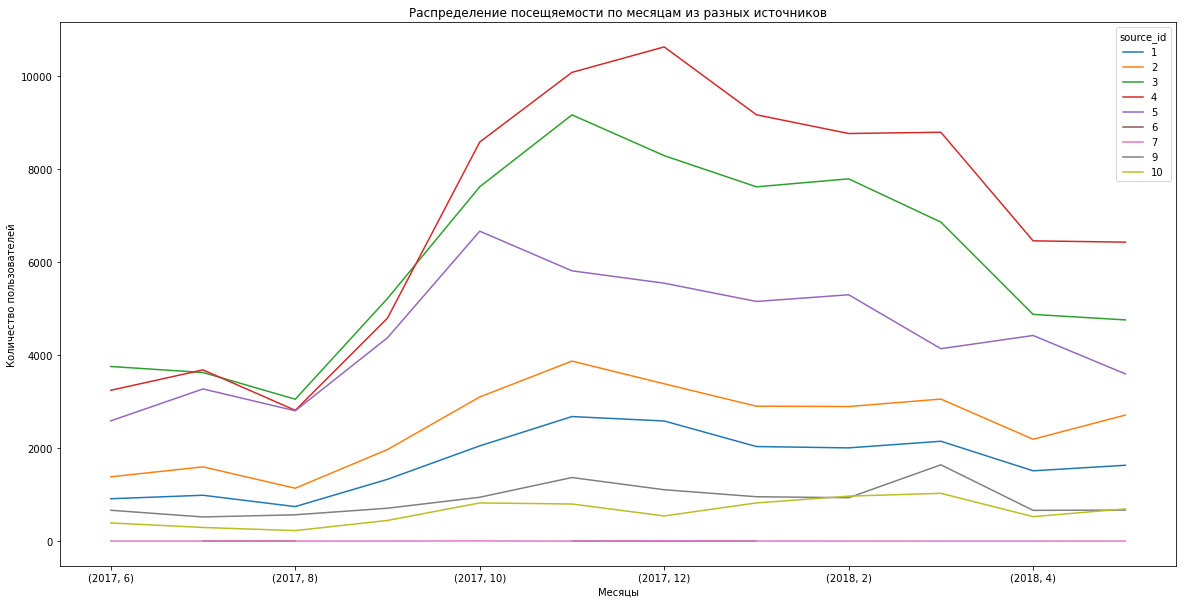

In [10]:
#Посчитаем сколько пользователей пользуется Яндекс.Афишей еженедельно. Метрика - MAU
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean().astype('int')
print('В среднем в месяц сервисом пользуется людей: ', mau_total['uid'])
visits.pivot_table(index=['session_year', 'session_month'], columns='device', values='uid', aggfunc='nunique').plot(figsize=(20,10))
plt.title('Распределение посещяемости по месяцам на разных платформах')
plt.xlabel("Месяцы")
plt.ylabel("Количество пользователей")
plt.show()
visits.pivot_table(index=['session_year', 'session_month'], columns='source_id', values='uid', aggfunc='nunique').plot(figsize=(20,10))
plt.title('Распределение посещяемости по месяцам из разных источников')
plt.xlabel("Месяцы")
plt.ylabel("Количество пользователей")
plt.show()

Так как все графики в этом блоке идейно про одно и тоже, только в разных временных разрезах, можно сделать общее резюме по ним всем разом. 

Инсайты из графиков по посещениям по платформам: 
* Мобильная платформа проигрывает десктопной. Учитывая то, что обеими платформами пользуется достаточно много людей, видимо версия десктопа удобнее для выбора и покупки билетов на мероприятия. 
* Паттерн роста и падения активности мобильной платформы и десктопной идентичны. Различие можно заметить только в графике по MAU на 52 неделю 2017 года, когда десктопная версия просела, а мобильная - поднялась. Видимо тогда десктопная версия дала сбой и люди заходили с мобильной. 
* Есть два выбивающихся артефакта. В конце ноября 2017 (сильный рост) и в апреле 2018 (сильный спад). Сильный спад на обоих версиях можно объяснить сбоем приложения. Сильный рост - 1) ошибкой данных при выгрузке 2) была введена какая-то очень выгодная промо-акция 3) началась продажа билетов на какое-то такое событие, котороые привлекло очень много желающих
* Поведение пользователей скачкообразное, что может свидетельствовать, что на сервис постоянно совершаются "набеги" пользователей при каких-то релизах или открытиях продаж. 

Инсайты из графиков по источникам трафика: 
* Топ источников по посещаемости - это 3,4,5. Источники 9 и 10 почти не приносят посетителей. На 7 источник почти нет надежд 
* Паттерны роста и падения  графиков почти сихронизированы между собой, т.е. нельзя сказать, что какой-то один из источников выбивается и имеет экстраординарные свойства. Тем не менее мы видим источник 7, который почти не приносит визитов, хочется сразу предположить, что он наименее полезный для ресурса. 

Общее количество посещений:
* В среднем в день сервисом пользуется людей:  817
* В среднем в неделю сервисом пользуется людей:  5148
* В среднем в месяц сервисом пользуется людей:  20955
Если дневные округлить до 1000, недельные до 5000, а месячные до 20000, то получим, что разница в средних значениях 4-5 раз. Примерно одинаковое соотношение данных параметров намекает нам на то, что данной информацией (имеется ввиду выгрузкой) можно и нужно пользоваться, данные имеют некую стабильность.

### Сколько сессий в день 

Сессий в день в среднем:  445
sticky factor =  0.03898830827964686


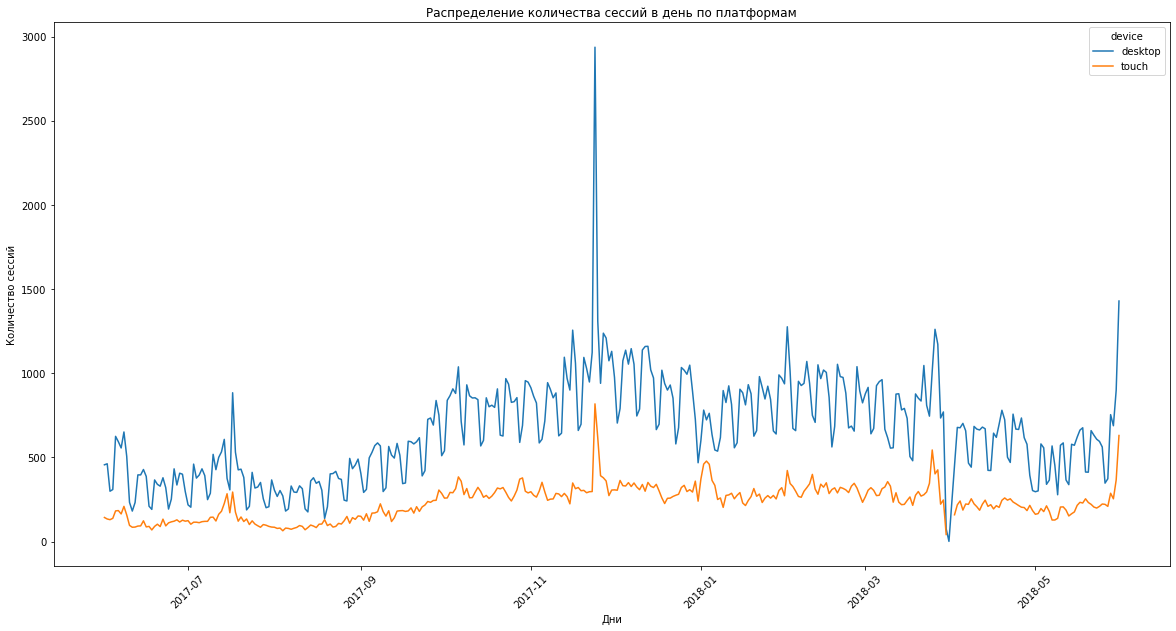

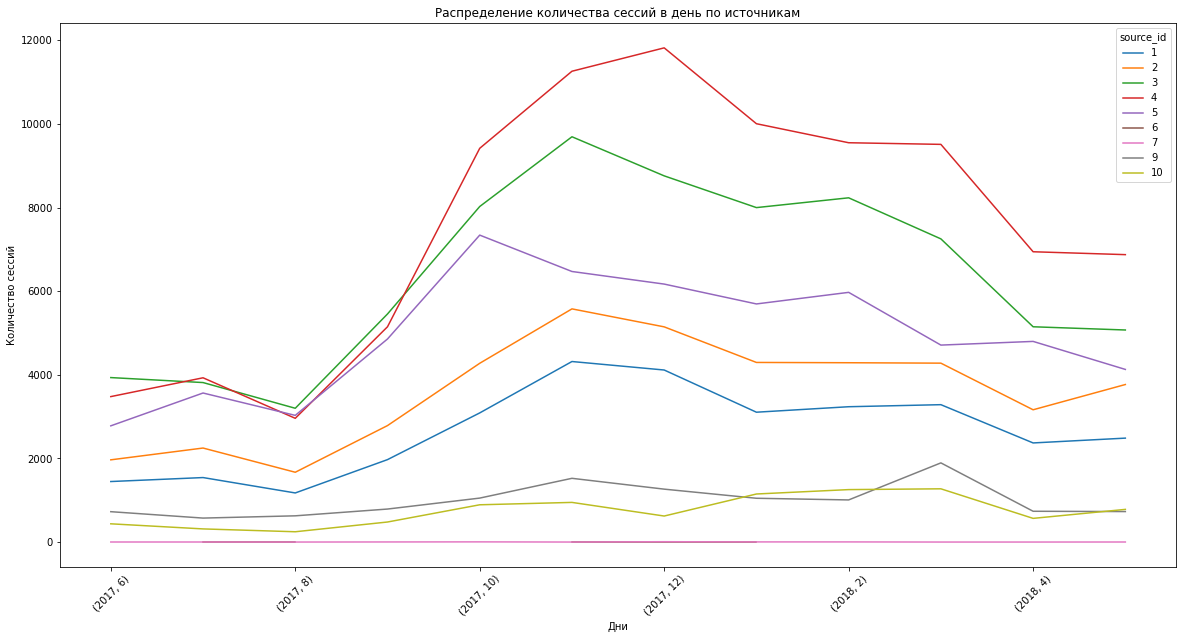

In [11]:
dau_session = visits.groupby(['device','session_date']).agg({'uid': 'count'}).mean().astype('int')
print('Сессий в день в среднем: ',dau_session['uid'])
print('sticky factor = ', dau_total['uid']/mau_total['uid'])
visits.pivot_table(index='session_date', columns='device', values='start_ts', aggfunc='count').plot(figsize=(20,10))
plt.xticks(rotation= 45)
plt.title('Распределение количества сессий в день по платформам')
plt.xlabel("Дни")
plt.ylabel("Количество сессий")
plt.show()
visits.pivot_table(index=['session_year', 'session_month'], columns='source_id', values='start_ts', aggfunc='count').plot(figsize=(20,10))
plt.xticks(rotation= 45)
plt.title('Распределение количества сессий в день по источникам')
plt.xlabel("Дни")
plt.ylabel("Количество сессий")
plt.show()

В целом выводы по графикам аналогичны выводам по посещаемости из предыдущего пункта: 1) Люди чаще заходят с ПК, чем с мобильной версии. 2) Топ источников по посещаемости - это 3,4,5. Источники 9 и 10 почти не приносят посетителей. Источник 7 не приносит ни единого посетителя. 

Если же говорить о метрике вовлечённости аудитории, то она составляет около 4%. Нельзя сказать, что она низкая, потому что мы не знаем средний бенчмарк этого показателя по приложениям такой категории. Но в целом эта метрика объяснима - редко какой пользователь будет заходить каждую неделю, чтобы посмотреть и купить билеты на различные мероприятия. Например, я могу опираться на свой опыт - я часто хожу на концерты и выставки, но билеты покупаю не каждую неделю или даже месяц. Возвращаться в приложение каждый раз нет необходимости. 

### Сколько длится одна сессия 

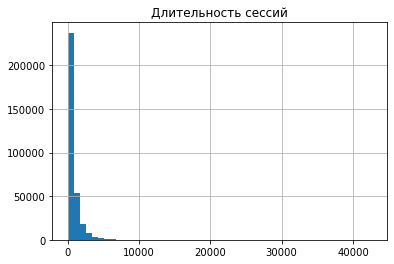

Т.к. распределение не нормального вида, рассчитаем моду
Мода составляет:  0    60
dtype: int64


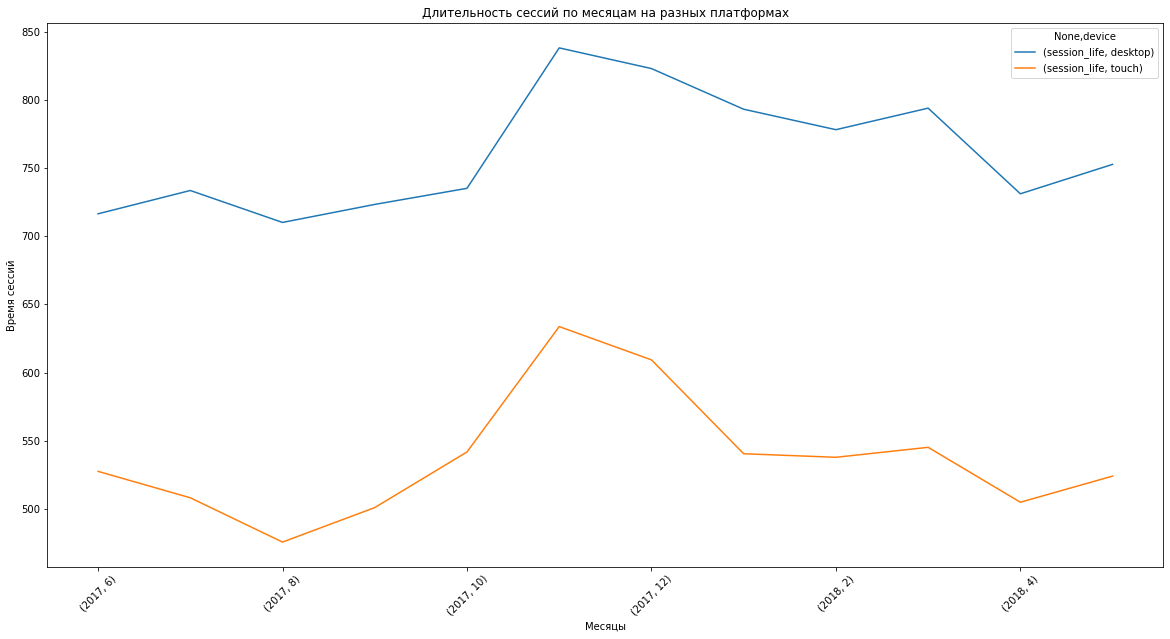

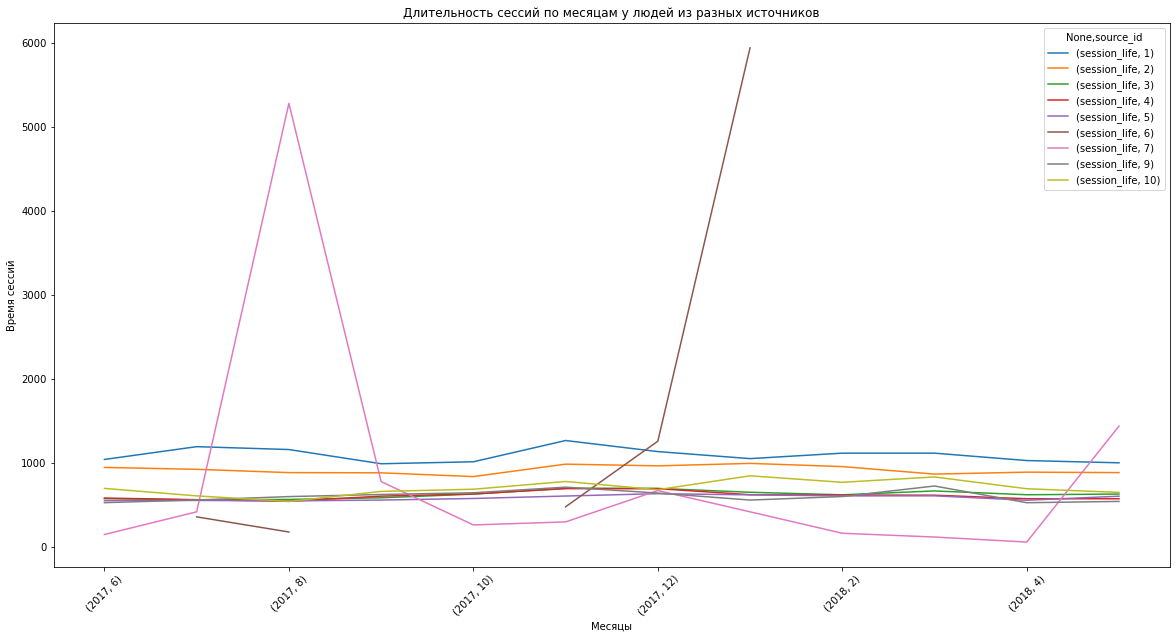

In [12]:
visits['session_life'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_life'].hist(bins=50)
plt.title('Длительность сессий')
plt.show()
print('Т.к. распределение не нормального вида, рассчитаем моду')
print('Мода составляет: ',visits['session_life'].mode())

visits.pivot_table(index=['session_year', 'session_month'], columns='device', values=['session_life']).plot(figsize=(20,10))
plt.xticks(rotation= 45)
plt.title('Длительность сессий по месяцам на разных платформах')
plt.xlabel("Месяцы")
plt.ylabel("Время сессий")
plt.show()

visits.pivot_table(index=['session_year', 'session_month'], columns='source_id', values=['session_life']).plot(figsize=(20,10))
plt.xticks(rotation= 45)
plt.title('Длительность сессий по месяцам у людей из разных источников')
plt.xlabel("Месяцы")
plt.ylabel("Время сессий")
plt.show()

* Длительность сессий на десктопе располагается параллельно мобильной, можно предположить, что это из-за того, что многие пользователи заходят на обоих типах устройств. Это хорошо, т.к. мобильная версия все равно востребована для пользователей десктопа.
* На графике с иточниками видно, что 6 и 7 в определенные моменты очень сильно взлетали, но затем снова падали на низкий уровень. Скорее всего, через них пытались агрессивно промотировать продукт, пытаясь возродить, но потом забросили, исчерпав ресурсы. Проверим эту теорию впоследствии. 

### Как часто люди возвращаются

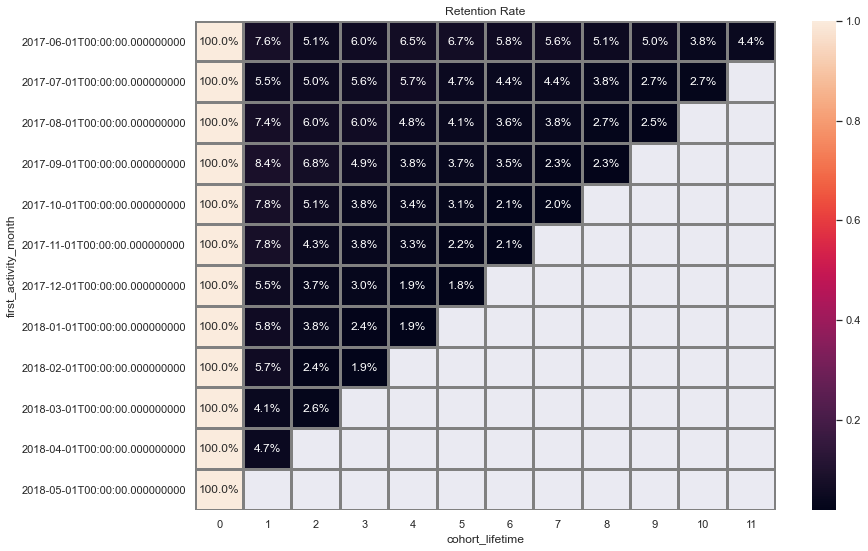

In [13]:
first_visits_date = visits.groupby(['uid'])['start_ts'].min()
first_visits_date.name = 'first_visits_date'
user_activity = visits.join(first_visits_date,on='uid')

user_activity['activity_month'] = user_activity['start_ts'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_visits_date'].astype('datetime64[M]')

user_activity['cohort_lifetime'] = user_activity['activity_month'] - user_activity['first_activity_month']
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')

cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=2, linecolor='grey')
plt.show()

In [14]:
first_device = user_activity.sort_values(by = 'start_ts', ascending = True).groupby(['uid']).agg({'device':'first'}).reset_index()
first_device = first_device.rename(columns={'device': 'first_device'})
user_activity2 = user_activity.merge(first_device, on='uid', how = 'left')

In [15]:

cohorts1 = user_activity2.groupby(['first_activity_month','cohort_lifetime', 'first_device']).agg({'uid':'nunique'}).reset_index()

initial_users_count1 = cohorts1[cohorts1['cohort_lifetime'] == 0][['first_activity_month','uid', 'first_device']]

initial_users_count1 = initial_users_count1.rename(columns={'uid':'cohort_users'})

cohorts1 = cohorts1.merge(initial_users_count1,on=['first_activity_month','first_device'])

cohorts1['retention'] = cohorts1['uid']/cohorts1['cohort_users']


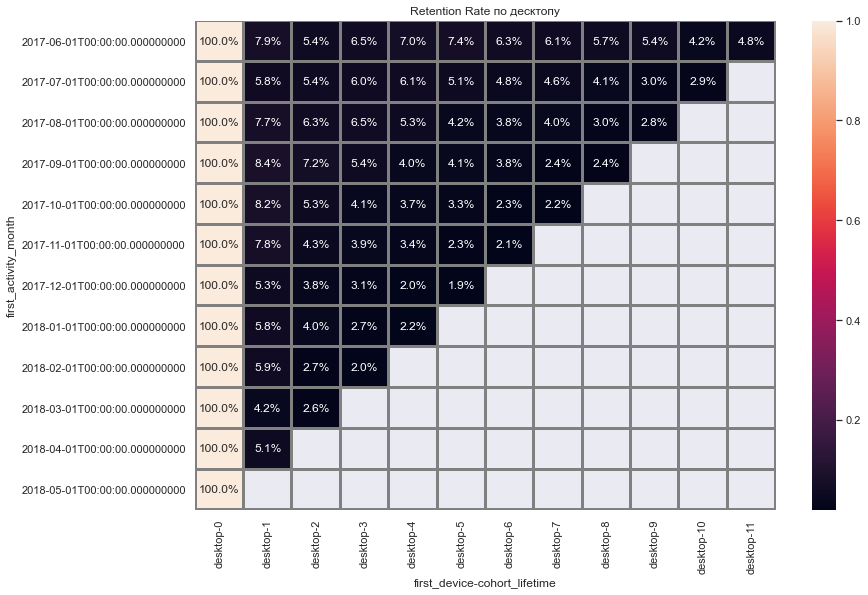

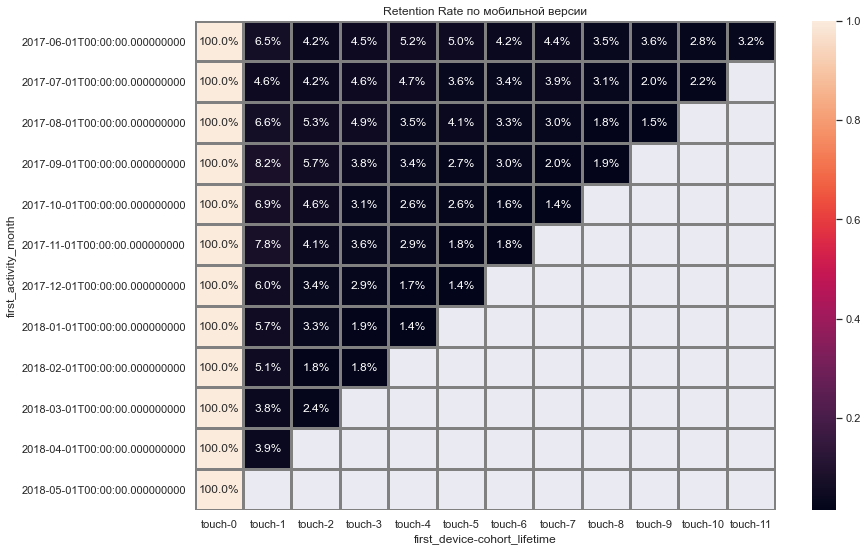

In [16]:
retention_pivot1 = cohorts1.query('first_device == "desktop"').pivot_table(index=['first_activity_month'],columns=['first_device','cohort_lifetime'],values='retention')
sns.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по десктопу')
sns.heatmap(retention_pivot1, annot=True, fmt='.1%', linewidths=2, linecolor='grey')
plt.show()
retention_pivot1 = cohorts1.query('first_device == "touch"').pivot_table(index=['first_activity_month'],columns=['first_device','cohort_lifetime'],values='retention')
sns.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по мобильной версии')
sns.heatmap(retention_pivot1, annot=True, fmt='.1%', linewidths=2, linecolor='grey')
plt.show()


* В разрезе времени и возраста когорт мы видим, что со временем люди все равно уходят, но это происходит постепенно. Данный процесс идет как внутри одной когорты, так и внутри нескольких, т.к. вторая когорта меньше первой. Именно поэтому подобные ресурсы стараются привлекать именно новых пользователей различными баллами и акциями.
* В разрезе платформ мы видим, что пользователи, которые чаще всего приходили через десктоп, будут приходить на него также часто, как и те, которые приходили и будут приходить на мобильную версию. В общем плане десктоп как платформа показывает себя более достойно, чем мобильная версия, что мы видели и в предыдущих графиках

## Построение отчетов и метрик продаж

### Когда люди начинают покупать

Средняя скорость регистрации-покупки в часах составляет:  5.201343809969105
Медианная скорость регистрации-покупки в часах составляет:  6.0653259773387465


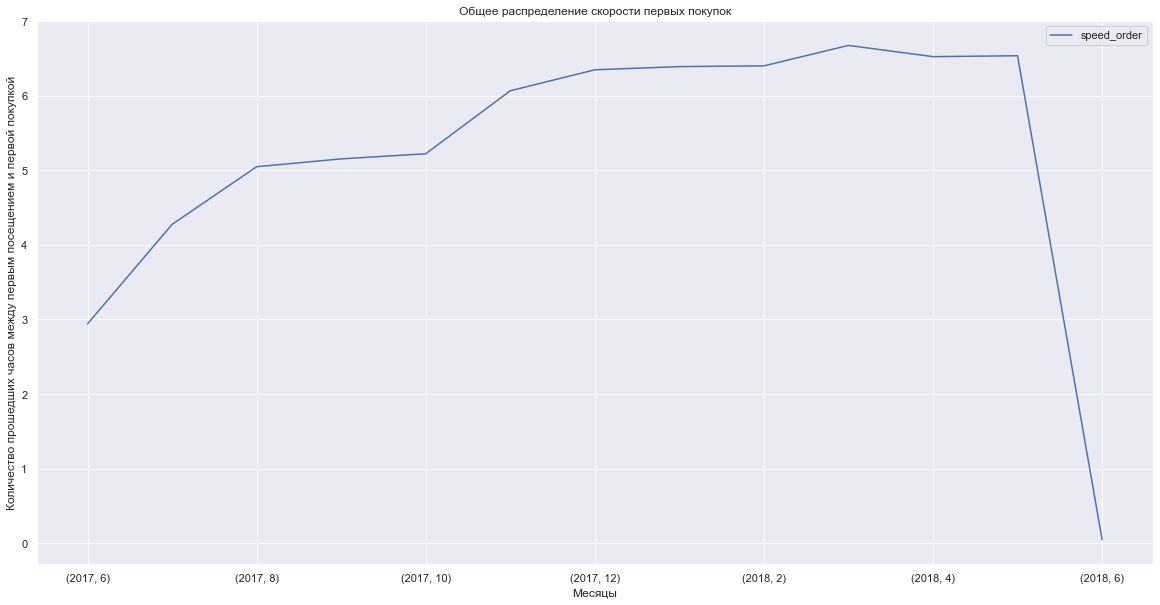

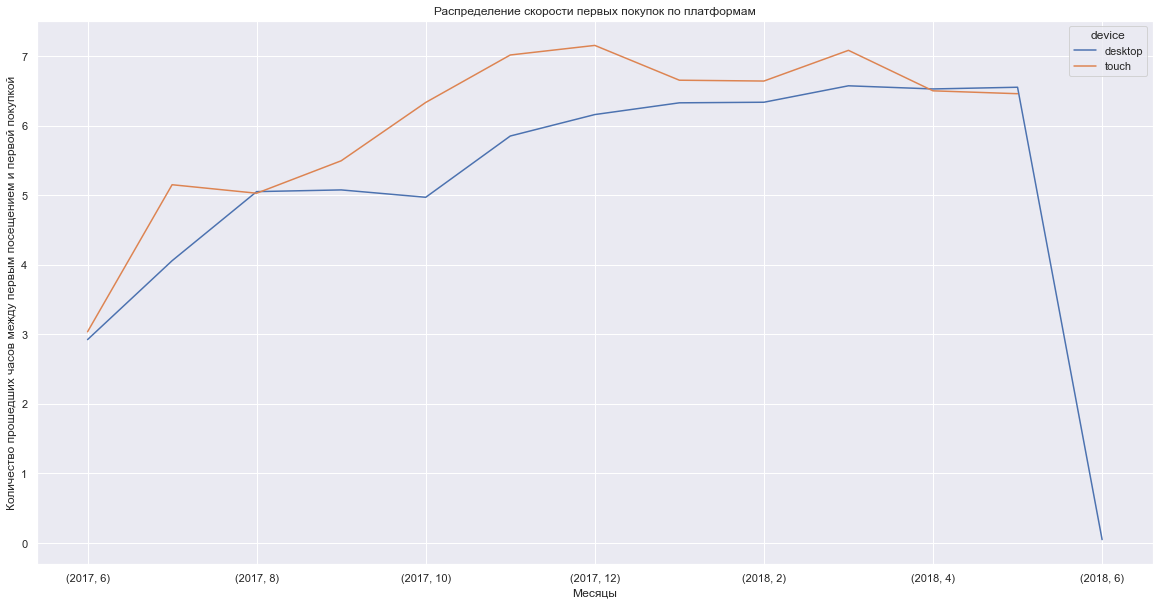

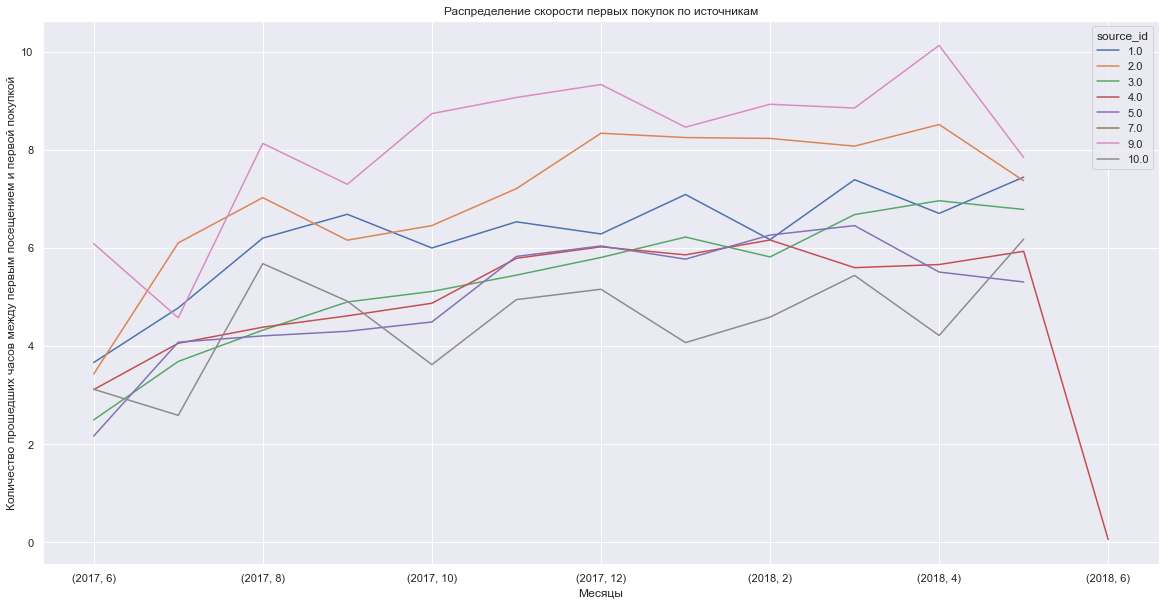

In [17]:
orders['month'] = orders['buy_ts'].dt.month
orders['year'] = orders['buy_ts'].dt.year

uid_and_device = visits.sort_values(by = 'start_ts', ascending = True).groupby(['uid']).first().reset_index()
orders_new = orders.merge(uid_and_device, on='uid', how='left')
orders_new['speed_order'] = ((orders_new['buy_ts'] - orders_new['start_ts']).dt.seconds)/3600

#Посчитали промежуток времени, который проходит между началом сессии и покупкой,перевели в часы, чтобы не иметь на графиках огромные числа
mean_speed = orders_new.pivot_table(index=['year', 'month'], values='speed_order').mean()
median_speed = orders_new.pivot_table(index=['year', 'month'], values='speed_order').median()
print('Средняя скорость регистрации-покупки в часах составляет: ', mean_speed['speed_order'])
print('Медианная скорость регистрации-покупки в часах составляет: ', median_speed['speed_order'])
#Посчитали и вывели метрику, усредненную для всех пользователей
#Также есть смысл вывести медиану, т.к. на общем графике видно, что в июне и июле 2017 данные набирали оборот почти с самой минимальной точки
orders_new.pivot_table(index=['year', 'month'], values='speed_order').plot(figsize=(20,10))
plt.title('Общее распределение скорости первых покупок')
plt.xlabel("Месяцы")
plt.ylabel("Количество прошедших часов между первым посещением и первой покупкой")
plt.show()

orders_new.pivot_table(index=['year', 'month'], columns='device', values='speed_order').plot(figsize=(20,10))
plt.title('Распределение скорости первых покупок по платформам')
plt.xlabel("Месяцы")
plt.ylabel("Количество прошедших часов между первым посещением и первой покупкой")
plt.show()
#Выводим ту же метрику, но с группировкой по девайсам. Ниже аналогично с источниками
orders_new.pivot_table(index=['year', 'month'], columns='source_id', values='speed_order').plot(figsize=(20,10))
plt.title('Распределение скорости первых покупок по источникам')
plt.xlabel("Месяцы")
plt.ylabel("Количество прошедших часов между первым посещением и первой покупкой")
plt.show()





* Распределение не является нормальным, именно поэтому медиана отличается от среднего. Награфиках видно, что линии резко обрываются к концу, это происходит из-за нехватки данных в данном участке исследований. Среднее считается из всех данных, даже некорректных, поэтому возьмем мидиану за основу. Скорость регистрации-покупки в часах составляет 6 часов
* Распределение по платформам показывает, пользователи десктопа привыкли совершать покупки быстрее. 6ч для регистрации-покупки для них нормально. Другое дело у мобильной версии около 7ч. Как мне кажется, это связано с тем, что регистрация и навигация по настольной версии происзодит гораздо быстрее, а значит и покупка.
* Распределение по источникам показывает, что люди, пришедшие из разных истончников, разбились на две когорты. 1: 1,2,9 - покупки по ним совершают гораздо быстрей. 2: 5,4,3,10. Напомню, что вследствии неполности данных при слиянии таблиц, у нас не отобразилась часть данных из других источников (6,8). Формально по источнику 7 есть данные, но на графике его не видно невооруженным взглядом. Разбиение источников на 2 когорты отчасти напоминает график по платформам. Возможно, эти источники как раз и отвечают за привлечение на десктоп и мобильную версию.

### Сколько раз покупают за период

Общее реднее количество покупок за месяц составляет:  3878.0
Среднее количество покупок за месяц у каждого источника составляет:  581.0


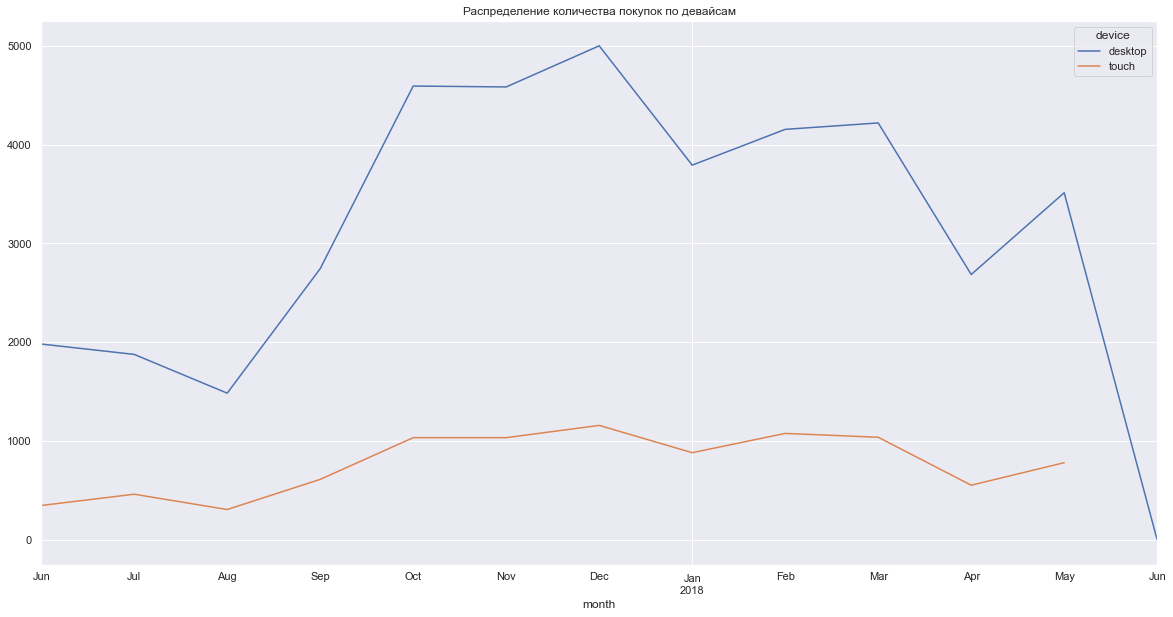

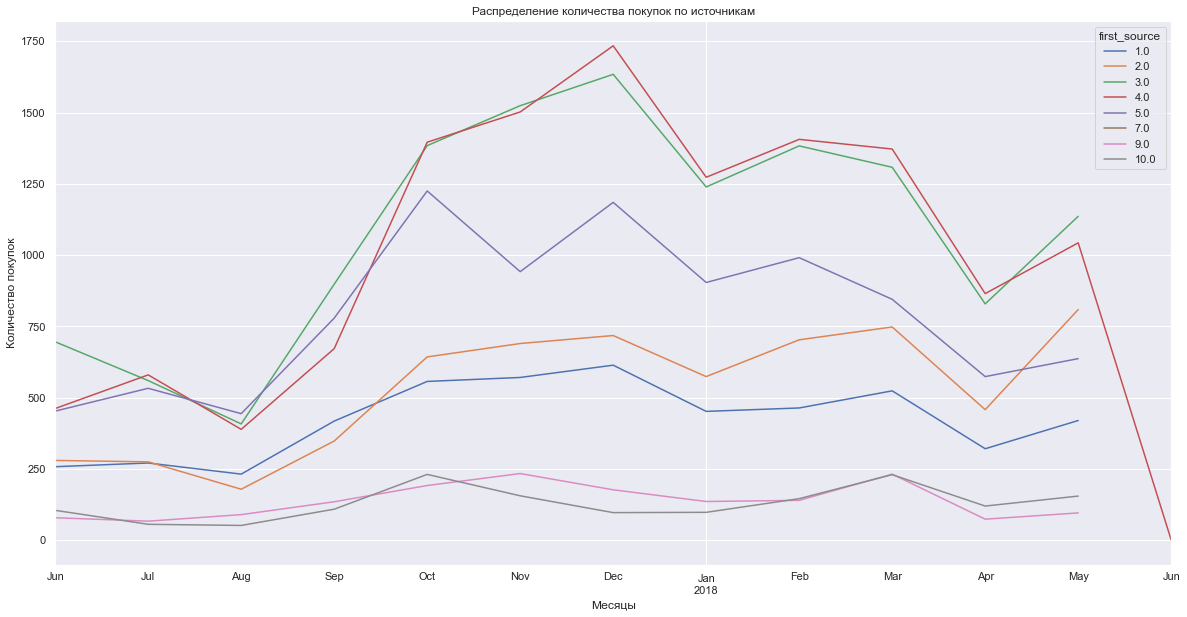

In [18]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
count_check_total = round(orders.groupby(['month']).agg({'uid':'count'}).mean())
print('Общее реднее количество покупок за месяц составляет: ', count_check_total['uid'])

uid_and_source = visits.sort_values(by = 'start_ts', ascending = True).groupby(['uid']).first().reset_index()
#взяли табличку с первыми источниками пользователя, ведь это именно те источники, откуда они пришли, то, что нам нужно для подсчета прибыльности
uid_and_source = uid_and_source.rename(columns={'source_id': 'first_source'})
orders = orders.merge(uid_and_source, on='uid', how='left')
#смерджили с заказами так, чтобы в таблице с заказами мы видели , из какого источника пришел пользователь.
count_check_total = round(orders.groupby(['month', 'first_source']).agg({'uid':'count'}).mean())
print('Среднее количество покупок за месяц у каждого источника составляет: ', count_check_total['uid'])

orders.pivot_table(index=['month'], columns='device', values='uid', aggfunc='count').plot(figsize=(20,10))
plt.title('Распределение количества покупок по девайсам')
plt.show()

orders.pivot_table(index=['month'], columns='first_source', values='uid', aggfunc='count').plot(figsize=(20,10))
#задали условия, когда дата покупки лежит внутри сессии пользователя, сгруппировали по времени, выведем источники с количеством uid как идентификатором покупки
plt.xlabel("Месяцы")
plt.ylabel("Количество покупок")
plt.title('Распределение количества покупок по источникам')
plt.show()

* Данные по платформам доказывают гипотезу, что явно не по всем заказам есть данные по сессии, поэтому мы видим максимальное значение покупок 35тыс. Тем не менее, отсюда можно увидеть, что количество покупок на мобильной версии в несколько раз ниже, чем количество покупок на десктопе. Потерянные данные о 15тыс заказах не смогли бы изменить соотношение. Можно смело сделать вывод, что десктоп, как платформа, более выгодна для вложений и продвижений.
* Источники разделились на 3 группы. Лидируют источники 3 и 4. Они собирают больше всего покупок. Далее источники 5,2,1. Они собирают почти в 2 раза меньше покупок, чем 3 и 4. Последние источники 9 и 10 отстают от 3 и 4 примерно в 15 раз.

### Какой средний чек

Средний чек составляет:  4.999646930476993
Медиана по чекам составляет:  2.5


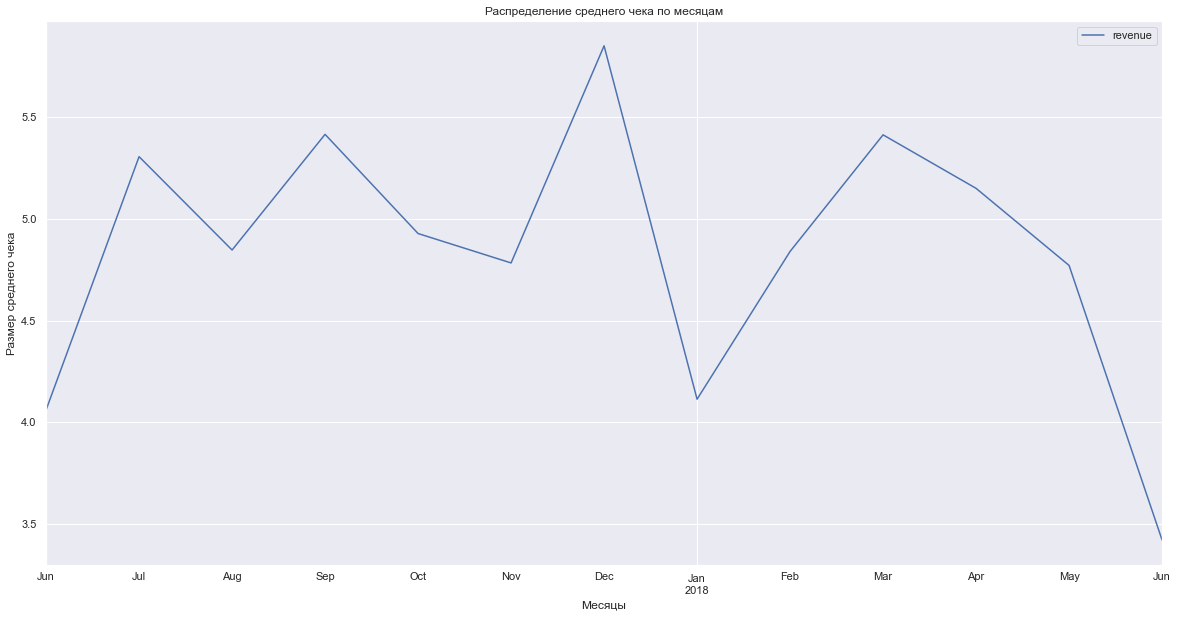

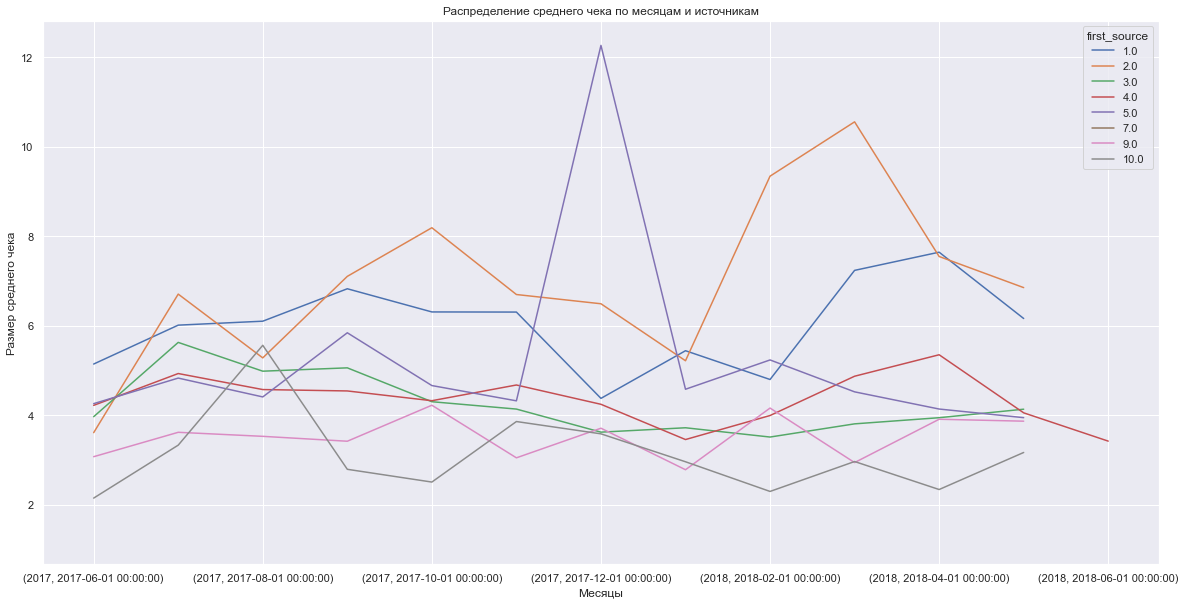

In [19]:
print('Средний чек составляет: ',orders['revenue'].mean())
print('Медиана по чекам составляет: ',orders['revenue'].median())
orders.groupby(['month']).agg({'revenue':'mean'}).reset_index().plot(x='month', y='revenue', figsize=(20,10))
plt.title('Распределение среднего чека по месяцам')
plt.xlabel("Месяцы")
plt.ylabel("Размер среднего чека")
plt.show()

orders.pivot_table(index=['year', 'month'], columns='first_source', values='revenue', aggfunc='mean').plot(figsize=(20,10))
plt.title('Распределение среднего чека по месяцам и источникам')
plt.xlabel("Месяцы")
plt.ylabel("Размер среднего чека")
plt.show()

* По общему распределению видно, что ситуация всегда более-менее стабильна, кроме конца декабря и начала января. Ситуация очевидная: в декабре многие хотят выбраться куда-то и есть очень много новогодних мероприятий, а в январе у многих отсутствие финансов из-за праздников
* Распределение по источникам на говорит о том, что , самые прибыльные - это 1(максимальный чек 15, средний около 7) и 2(максимальный чек 7.5, средний около 6). Остальные держатся на одном уровне.
* По общим данным средний чек составляет:  4.99, медиана по чекам составляет:  2.5. Эта разница возкает из-за сезонного поднятия и спада продаж в декабре-январе, а также из-за неоплноты данных. Логичней взять медиану для дальнейших манипуляций с данными

### Сколько денег приносят (LTV)

In [20]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby(['uid']).agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month' ]
first_orders['first_order_month'] = first_orders['first_order_month'].astype('datetime64[M]')
orders2 = orders.merge(first_orders, on = 'uid', how = 'left')

In [21]:
#Находим даты первых покупок
cohort_sizes = orders2.groupby(['first_order_month', 'first_source']).agg({'uid': 'nunique'}).reset_index()
#Вычисляем число новых покупателей за каждую дату
cohort_sizes.columns = ['first_order_month','first_source','n_buyers']

In [22]:
cohorts = orders2.groupby(['first_order_month','order_month', 'first_source']).agg({'revenue': 'sum'}).reset_index()
#Добавляем дату первой покупки в таблицу с заказами
#Группируем таблицу и считаем выручку
report = pd.merge(cohort_sizes, cohorts, on=['first_order_month','first_source'])
#Добавляем полученные данные к количеству покупателей

Средние LTV по всем когортам:


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.507941,5.061443,5.697361,6.898030,8.214953,9.081511,10.230598,11.012504,11.675836,12.345721,13.018243,13.485499
2017-07-01,5.834682,6.518193,7.727420,8.220906,8.527552,8.754390,8.951092,9.137141,9.371376,9.598913,9.857130,NaN
2017-08-01,4.862946,5.370398,5.875591,6.306085,6.809808,7.089626,7.339059,7.910617,8.364460,8.585693,NaN,NaN
2017-09-01,5.339367,7.020482,7.704485,10.510029,10.954401,11.552921,12.496194,12.830314,13.164960,NaN,NaN,NaN
2017-10-01,5.099905,5.818063,6.069730,6.264671,6.445220,6.619037,6.700530,6.831416,NaN,NaN,NaN,NaN
2017-11-01,5.279164,5.653281,5.911592,6.296983,6.453860,6.517286,6.612186,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.901771,5.281837,6.937763,8.883433,9.416930,9.932763,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.033602,4.352661,4.748265,4.989724,5.077758,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.213940,4.565524,4.656281,4.744896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age
0      4.736766
1      5.456414
2      6.106504
3      7.012751
4      7.737560
5      8.506791
6      8.721610
7      9.544399
8     10.644158
9     10.176775
10    11.437687
11    13.485499
dtype: float64

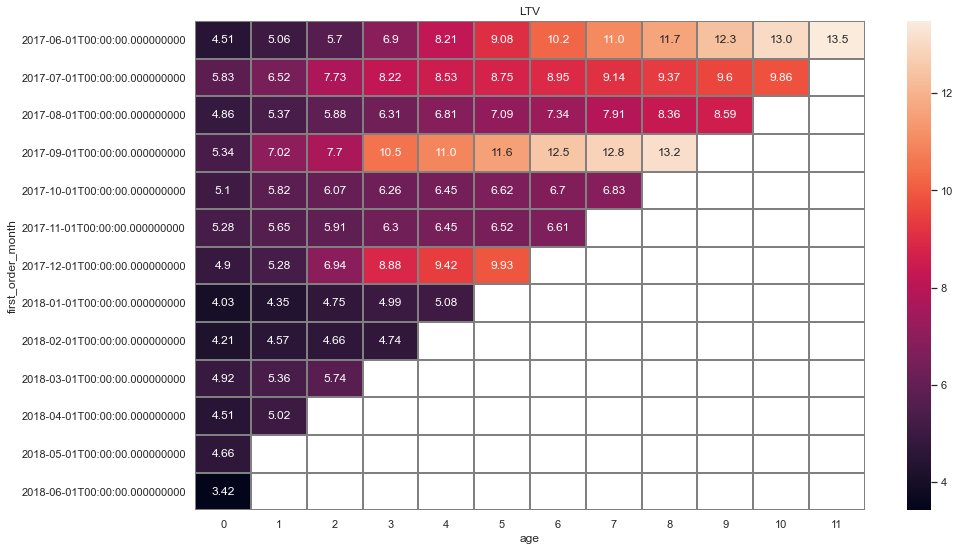

In [23]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

#Считаем основные метрики
print('Средние LTV по всем когортам:')
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean',
        )

#Накопительный LTV по когортам 
output_ltv_sum = output.cumsum(axis = 1)
display(output_ltv_sum)

display(output.cumsum(axis=1).mean(axis=0))

#Выводим сводную таблицу с полученными значениями ltv
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV')
sns.heatmap(output_ltv_sum, annot=True, fmt='.3',linewidths=1, linecolor='gray')
plt.show()


Видим, что самый высокий ltv у сентябрьской когорты, на втором месте - июньская когорта, на третьем - июльская. 

----------------------------------
LTV по источникам


first_source,1.0,2.0,3.0,4.0,5.0,7.0,9.0,10.0
first_order_month,,,,,,,,
2017-06-01,2.31603,1.39179,0.475161,1.011364,1.20178,,0.631217,0.824529
2017-07-01,1.85371,1.061,0.672345,0.572023,0.55881,,0.670463,1.66522
2017-08-01,1.90414,0.838057,0.636165,0.640850,1.00538,1.22,0.592525,1.13086
2017-09-01,1.2389,2.93015,0.740548,0.865927,2.944,,1.05876,0.372627
2017-10-01,1.03426,1.57905,0.711425,0.654826,0.771678,,0.87315,0.353107
2017-11-01,1.44312,1.37896,0.714398,0.962724,0.753652,,0.641244,0.718084
2017-12-01,0.90885,6.06984,0.792926,0.754493,0.90057,,0.790901,1.36293
2018-01-01,1.40591,1.55723,0.906002,0.820991,1.07275,,0.647398,1.05447
2018-02-01,1.43484,1.65028,1.06099,1.064062,1.12464,,1.71024,0.855702


Суммарный LTV по источникам:


first_source
1.0     11.456540
2.0     13.105403
3.0      5.391657
4.0      7.014053
5.0      8.110882
7.0      1.220000
9.0      5.715248
10.0     6.649933
dtype: float64

Средний LTV по всем источникам:
7.332964461121996


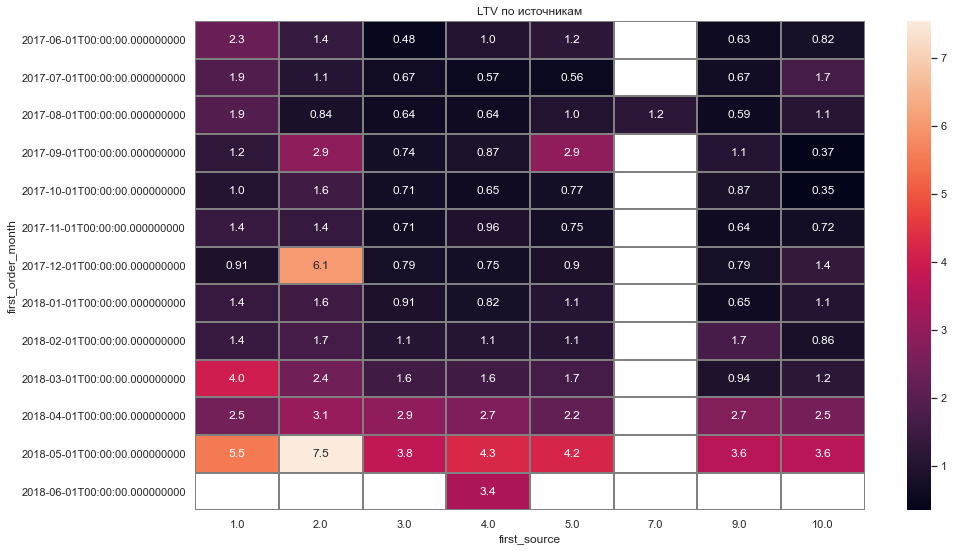

In [24]:
print('----------------------------------')
print('LTV по источникам')

output_source = report.pivot_table(
        index='first_order_month', 
        columns='first_source', 
        values='ltv', 
        aggfunc='mean')
display(output_source.fillna(''))

print('Суммарный LTV по источникам:')
display(output_source.cumsum(axis=0).mean(axis=0))
print('Средний LTV по всем источникам:')
print((output_source.cumsum(axis=0).mean(axis=0)).mean())

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV по источникам')
sns.heatmap(output_source, annot=True, fmt='.2',linewidths=1, linecolor='gray')
plt.show()

* Источники 1 и 2 приводят самых ценных клиентов
* По источникам видно, что 4,2,5,1 приносят ощутимую прибыль, а 7,9,3 приносят меньше всего денег

#### Всё что мы узнали из вышерассчитанных метрик:
* Люди принимают решение о покупке через 6,3ч после регистрации
* Пользователи десктопа совершают покупки быстрей, чем пользователи мобильной версии
* Больше всего покупок совершили люди из источников 3,4. Меньше всего покупок из источников 9 и 10. 1,2,4 источники самые прибыльные.
* Средний(т.е. медианный) чек : 2,5
* Источники 1 и 2 приводят самых ценных клиентов

## Построение отчетов и метрик маркетинга

### Сколько денег потратили

Всего было потрачено:  329131.62


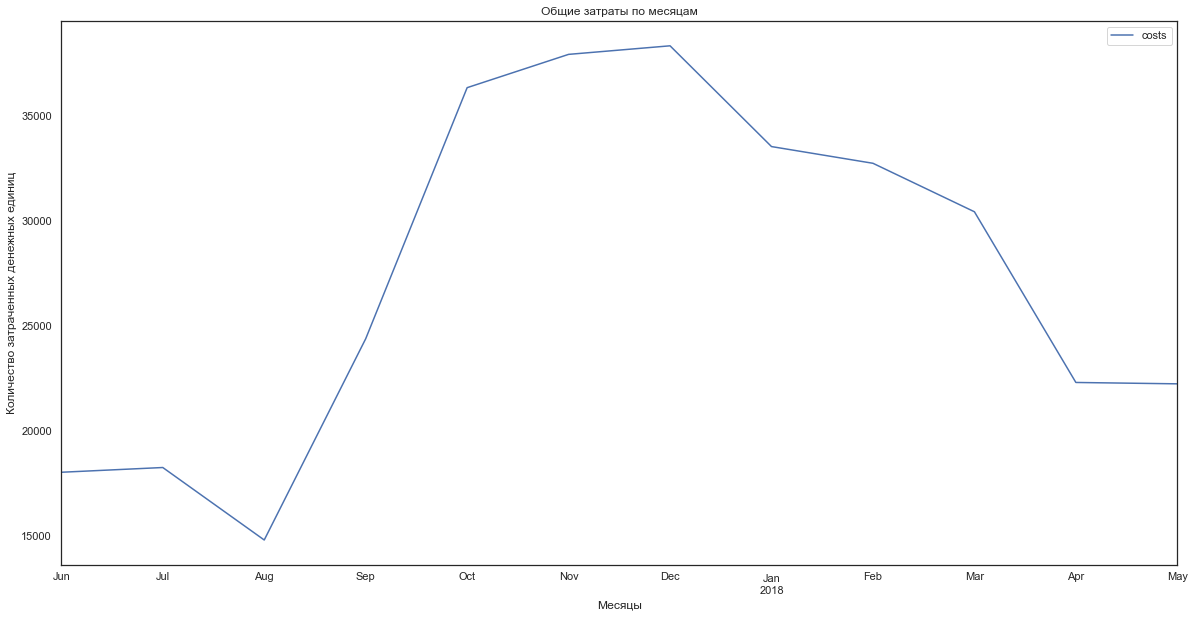

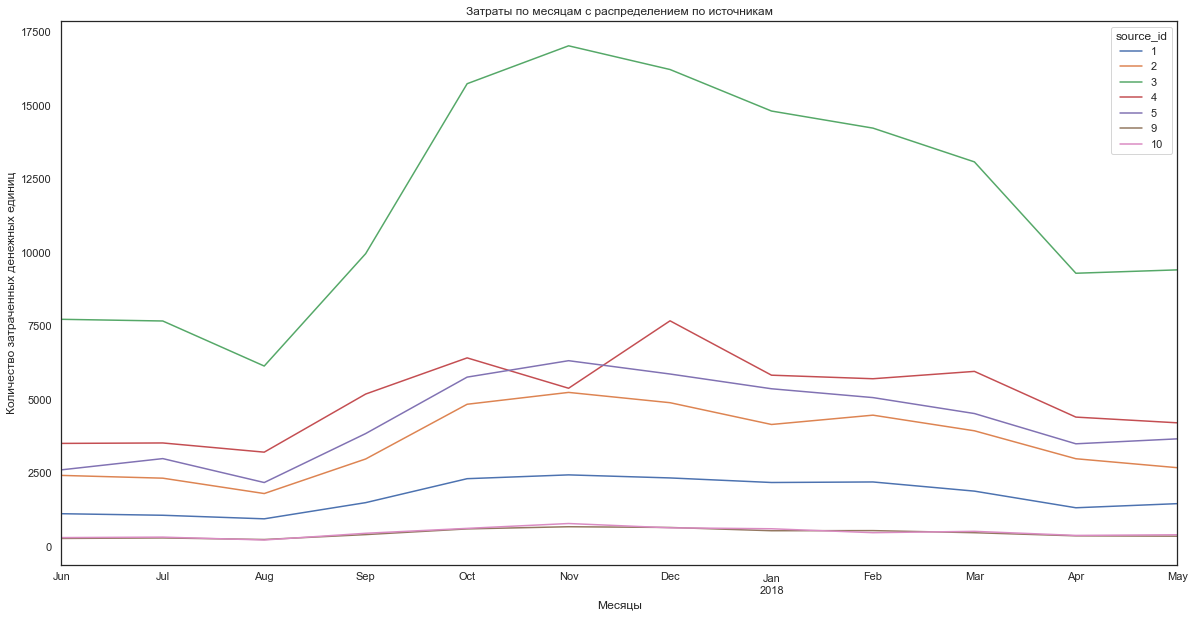

In [25]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_total = costs['costs'].sum()
print('Всего было потрачено: ',costs_total)
costs_month = costs.groupby(['month']).agg({'costs':'sum'})
costs_month.plot(figsize=(20,10))
plt.title('Общие затраты по месяцам')
plt.xlabel("Месяцы")
plt.ylabel("Количество затраченных денежных единиц")
plt.show()
costs_source = costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
costs_source.plot(figsize=(20,10))
plt.title('Затраты по месяцам с распределением по источникам')
plt.xlabel("Месяцы")
plt.ylabel("Количество затраченных денежных единиц")
plt.show()

* Общее распределение показывает, что компания резко увеличила вложения в маркетинг 08-09.2018 Это привело к положительной отдаче, которую мы видели ранее, поэтому для компании появился смысл ослабить поток вложений для попытки нормализовать соотношения уход\приход финансов.
* По источникам видно, что отдел маркетинга сильнее всего пытается раскрутить источник 3. Далее идет источники 4,5,2. Остальные источники вовсе не получают финансирование
* Источники 6,7,8 отсутствуют в статистике, т.к. маркетинг не вкладывался в них.

### Сколько стоило привлечение одного покупателя из каждого источника

In [26]:
costs_month1 = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()

report_new2 = pd.merge(report, costs_month1, left_on=['first_order_month','first_source'], right_on=['month','source_id'])
report_new2['cac'] = report_new2['costs'] / report_new2['n_buyers']
output2 = report_new2.pivot_table(
        index='month', 
        columns='source_id', 
        values='cac')

print('Стоимость привлечения покупателя в разбивке на когорты и источники')
display(output2)
print('Стоимость привлечения покупателя в сумме по источникам')
print(output2.mean(axis=0))
print('Средняя стоимость привлечения покупателя по источникам')
print('В среднем привлечение одного клиента стоило:',output2.mean(axis=0).mean())

Стоимость привлечения покупателя в разбивке на когорты и источники


source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,5.924263,10.462845,12.272460,8.572683,6.866457,4.194412,3.415435
2017-07-01,6.463133,11.325777,15.379499,6.907495,7.189784,5.708302,6.467059
2017-08-01,8.423097,14.723984,18.122537,9.661742,6.208182,4.080820,6.285676
2017-09-01,6.391532,13.269600,13.092707,8.998718,6.636448,4.722955,5.295057
2017-10-01,6.731831,12.584416,13.951454,5.530439,6.148614,4.798504,3.044854
2017-11-01,7.320838,13.021538,14.271031,4.633551,9.193808,4.914964,6.288571
2017-12-01,6.906195,12.623196,12.583026,5.714635,7.696619,5.306290,7.781446
2018-01-01,8.996626,14.238836,15.019047,5.803771,8.472429,6.592289,6.981250
2018-02-01,7.762254,15.014564,13.360150,5.264479,7.591781,6.488235,3.974215


Стоимость привлечения покупателя в сумме по источникам
source_id
1      7.062507
2     12.462621
3     14.073269
4      6.548651
5      7.550768
9      5.451785
10     4.945414
dtype: float64
Средняя стоимость привлечения покупателя по источникам
В среднем привлечение одного клиента стоило: 8.29928780542508


* Очень дорогое привлечение одного клиента: 8,3
* Самый дорогой источник по привлечению №3
* Источники 4,9,10 самые дешевые

### На сколько окупились расходы (ROI)

ROMI


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.687446,0.771856,0.876401,1.04739,1.23558,1.35777,1.51901,1.62815,1.72617,1.81885,1.90404,1.97477
2017-07-01,0.737316,0.834117,1.0182,1.08732,1.1302,1.16195,1.18919,1.21421,1.24916,1.28101,1.3149,
2017-08-01,0.669392,0.73111,0.805263,0.862471,0.924763,0.961966,0.995033,1.06626,1.12222,1.15155,,
2017-09-01,0.683779,0.856571,0.937029,1.35606,1.41074,1.48718,1.58474,1.63132,1.68338,,,
2017-10-01,0.769396,0.854016,0.88826,0.913421,0.938445,0.966001,0.978289,0.996509,,,,
2017-11-01,0.708933,0.759427,0.791628,0.844345,0.865613,0.873575,0.887486,,,,,
2017-12-01,0.611547,0.652462,0.792065,0.955368,0.999167,1.04478,,,,,,
2018-01-01,0.464590,0.495382,0.53098,0.556399,0.563891,,,,,,,
2018-02-01,0.564578,0.604758,0.613603,0.621449,,,,,,,,


age
0     0.669427
1     0.728569
2     0.816204
3     0.916025
4     1.008551
5     1.121888
6     1.192292
7     1.307289
8     1.445231
9     1.417136
10    1.609467
11    1.974767
dtype: float64


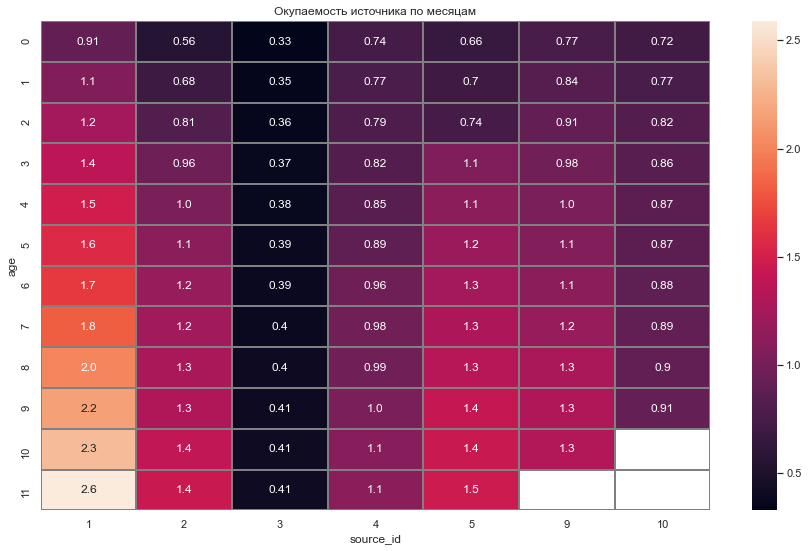

In [27]:
report_new2['romi'] = report_new2['ltv'] / report_new2['cac']
print('ROMI')
romi = report_new2.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1)
display(romi.fillna(''))
print(romi.mean())

#Рассчитаем на какой месяц жизни в среднем окупается источник 
romi_roi = report_new2.pivot_table(
        index='age', 
        columns='source_id', 
        values='romi', 
        aggfunc='mean').cumsum()

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Окупаемость источника по месяцам')
sns.heatmap(romi_roi, annot=True, fmt='.2',linewidths=1, linecolor='gray')
plt.show()

* Мы видим, что окупаемость когорт происходит в среднем на 4 месяц. 
* В разрезе источников мы видим, что 1 источник окупается за первый месяц, 2 - на 4 месяц, 3 - не окупается вовсе, 4 - на 9 месяц, 5 - на 3 месяц, 9 - на 4 месяц, 10 - пока не окупается. 

In [28]:

print('ROMI для источника 1')
romi_source = report_new2.query('first_source == 1').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

print('---------------------------')
print('ROMI для источника 2')
romi_source = report_new2.query('first_source == 2').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

print('---------------------------')
print('ROMI для источника 3')
romi_source = report_new2.query('first_source == 3').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

ROMI для источника 1


first_source            1.0                                                \
age                      0          1           2          3           4    
first_order_month                                                           
2017-06-01         1.178676   0.374099    0.349348    0.37569    0.606747   
2017-07-01         1.125923   0.163401     0.79954   0.224741    0.130984   
2017-08-01         0.889442    0.16268    0.136634   0.120318    0.123386   
2017-09-01         0.943396   0.280444    0.136304   0.162309   0.0109453   
2017-10-01         0.879745   0.155228   0.0353017  0.0569405   0.0103984   
2017-11-01         1.011496  0.0760318    0.127681    0.11845   0.0219822   
2017-12-01         0.659807   0.038728   0.0398343  0.0339484  0.00375876   
2018-01-01         0.640464  0.0098528     0.01853   0.106638  0.00586868   
2018-02-01         0.589953   0.128239  0.00840107  0.0128012               
2018-03-01         1.395306   0.289268    0.113206                          
2018-04-01         0.640231  0.0370775                                      
2018-05-01         0.947438                                                 

first_source                                                             \
age                       5          6          7         8          9    
first_order_month                                                         
2017-06-01          0.272501   0.327609   0.320502  0.261956   0.170965   
2017-07-01            0.1342  0.0666431  0.0963575  0.127815    0.14695   
2017-08-01         0.0791124  0.0807514   0.315462  0.260378  0.0924554   
2017-09-01         0.0144074  0.0177229  0.0654123  0.113568              
2017-10-01         0.0158869  0.0269157  0.0486797                        
2017-11-01           0.01404  0.0101957                                   
2017-12-01         0.0135187                                              
2018-01-01                                                                
2018-02-01                                                                
2018-03-01                                                                
2018-04-01                                                                
2018-05-01                                                                

first_source                           
age                      10        11  
first_order_month                      
2017-06-01         0.172804  0.280372  
2017-07-01         0.138385            
2017-08-01                             
2017-09-01                             
2017-10-01                             
2017-11-01                             
2017-12-01                             
2018-01-01                             
2018-02-01                             
2018-03-01                             
2018-04-01                             
2018-05-01

---------------------------
ROMI для источника 2


first_source            2.0                                              \
age                      0          1          2          3          4    
first_order_month                                                         
2017-06-01         0.416325  0.0475986  0.0263247   0.186127   0.161367   
2017-07-01         0.740762  0.0682522  0.0262439  0.0273798   0.038528   
2017-08-01         0.398631  0.0527705  0.0134618  0.0170398  0.0349852   
2017-09-01         0.623862   0.601673   0.174869  0.0683199   0.104235   
2017-10-01         0.616784   0.200729  0.0540062   0.043001  0.0398927   
2017-11-01         0.531488  0.0689066  0.0352041  0.0594282  0.0244489   
2017-12-01         0.684954   0.122867   0.725854   0.864192   0.236884   
2018-01-01         0.304750   0.076556   0.122006  0.0189959  0.0245157   
2018-02-01         0.359827  0.0419168  0.0211629  0.0167399              
2018-03-01         0.445242  0.0669517   0.109372                         
2018-04-01         0.409450  0.0324081                                    
2018-05-01         1.161346                                               

first_source                                                                  \
age                        5           6          7           8           9    
first_order_month                                                              
2017-06-01            0.08875    0.154521   0.143488    0.129275   0.0710313   
2017-07-01          0.0166044   0.0266426  0.0128455  0.00990523   0.0204191   
2017-08-01         0.00563209  0.00995003  0.0266972  0.00225284  0.00775793   
2017-09-01          0.0721649    0.245587  0.0557632   0.0408754               
2017-10-01          0.0217709  0.00776883  0.0198576                           
2017-11-01            0.01086   0.0109534                                      
2017-12-01           0.250335                                                  
2018-01-01                                                                     
2018-02-01                                                                     
2018-03-01                                                                     
2018-04-01                                                                     
2018-05-01                                                                     

first_source                             
age                       10         11  
first_order_month                        
2017-06-01          0.131529  0.0399319  
2017-07-01         0.0428998             
2017-08-01                               
2017-09-01                               
2017-10-01                               
2017-11-01                               
2017-12-01                               
2018-01-01                               
2018-02-01                               
2018-03-01                               
2018-04-01                               
2018-05-01

---------------------------
ROMI для источника 3


first_source            3.0                                                  \
age                      0           1           2           3           4    
first_order_month                                                             
2017-06-01         0.357009  0.00930849   0.0153822   0.0256802    0.015324   
2017-07-01         0.401138    0.014839  0.00811923   0.0262849  0.00266732   
2017-08-01         0.293009  0.00849022   0.0157955  0.00586795  0.00888901   
2017-09-01         0.424383    0.017839   0.0178129  0.00480853   0.0167641   
2017-10-01         0.340399   0.0329225  0.00880968  0.00450651  0.00765954   
2017-11-01         0.318816  0.00905063  0.00594995  0.00851965  0.00358289   
2017-12-01         0.333109    0.010914   0.0109689   0.0101458  0.00800332   
2018-01-01         0.272584   0.0122387  0.00848753  0.00488426  0.00342364   
2018-02-01         0.282413   0.0237649  0.00676878  0.00471024               
2018-03-01         0.304334  0.00750716   0.0249762                           
2018-04-01         0.292009   0.0925877                                       
2018-05-01         0.325582                                                   

first_source                                                                   \
age                        5           6           7           8           9    
first_order_month                                                               
2017-06-01          0.0159449   0.0105553   0.0024432  0.00412978  0.00437681   
2017-07-01         0.00473524  0.00243538  0.00862872  0.00561088  0.00272205   
2017-08-01         0.00270365  0.00353542  0.00508664  0.00431673  0.00334172   
2017-09-01         0.00933603  0.00924871  0.00310432     0.00576               
2017-10-01         0.00682203  0.00144498  0.00537896                           
2017-11-01         0.00226134   0.0022349                                       
2017-12-01         0.00495206                                                   
2018-01-01                                                                      
2018-02-01                                                                      
2018-03-01                                                                      
2018-04-01                                                                      
2018-05-01                                                                      

first_source                               
age                        10          11  
first_order_month                          
2017-06-01         0.00232421  0.00213409  
2017-07-01         0.00370584              
2017-08-01                                 
2017-09-01                                 
2017-10-01                                 
2017-11-01                                 
2017-12-01                                 
2018-01-01                                 
2018-02-01                                 
2018-03-01                                 
2018-04-01                                 
2018-05-01

In [29]:
print('ROMI для источника 4')
romi_source = report_new2.query('first_source == 4').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

print('---------------------------')
print('ROMI для источника 5')
romi_source = report_new2.query('first_source == 5').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

print('---------------------------')
print('ROMI для источника 9')
romi_source = report_new2.query('first_source == 9').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

print('---------------------------')
print('ROMI для источника 10')
romi_source = report_new2.query('first_source == 10').pivot_table(
        index='first_order_month', 
        columns=['first_source', 'age'], 
        values='romi', 
        aggfunc='mean')
display(romi_source.fillna(''))

ROMI для источника 4


first_source            4.0                                                  \
age                      0           1           2           3           4    
first_order_month                                                             
2017-06-01         0.554566  0.00473996    0.020078   0.0539832    0.133205   
2017-07-01         0.805404  0.00865505   0.0120802   0.0234636  0.00819609   
2017-08-01         0.521375   0.0177195   0.0110929    0.026357   0.0153697   
2017-09-01         0.531988   0.0546178   0.0356203   0.0329702  0.00561798   
2017-10-01         0.804339   0.0278499   0.0261165    0.018767   0.0254717   
2017-11-01         1.100050    0.143592   0.0218285   0.0888599   0.0422226   
2017-12-01         0.725547   0.0122675   0.0168792   0.0153584  0.00713628   
2018-01-01         0.654901   0.0210825   0.0148951   0.0114542  0.00495818   
2018-02-01         0.776758   0.0213272  0.00681552  0.00358371               
2018-03-01         0.812641   0.0178199   0.0161761                           
2018-04-01         0.785816   0.0336328                                       
2018-05-01         0.799277                                                   

first_source                                                                  \
age                        5           6          7           8           9    
first_order_month                                                              
2017-06-01           0.174949     0.16795  0.0273899   0.0254467   0.0943126   
2017-07-01         0.00911968    0.014953  0.0066294   0.0102982  0.00892703   
2017-08-01          0.0211757  0.00873698  0.0199107  0.00974401   0.0118047   
2017-09-01          0.0269497    0.142574  0.0298502  0.00586257               
2017-10-01          0.0171769   0.0160337  0.0114767                           
2017-11-01         0.00955497      0.0483                                      
2017-12-01          0.0149809                                                  
2018-01-01                                                                     
2018-02-01                                                                     
2018-03-01                                                                     
2018-04-01                                                                     
2018-05-01                                                                     

first_source                               
age                        10          11  
first_order_month                          
2017-06-01           0.149107  0.00997496  
2017-07-01         0.00320421              
2017-08-01                                 
2017-09-01                                 
2017-10-01                                 
2017-11-01                                 
2017-12-01                                 
2018-01-01                                 
2018-02-01                                 
2018-03-01                                 
2018-04-01                                 
2018-05-01

---------------------------
ROMI для источника 5


first_source            5.0                                                  \
age                      0           1           2           3           4    
first_order_month                                                             
2017-06-01         0.737199    0.133939   0.0759636    0.239683    0.148716   
2017-07-01         0.741513     0.01083   0.0119708     0.01612   0.0136818   
2017-08-01         0.789702     0.12392    0.132551    0.117019    0.177867   
2017-09-01         0.939493   0.0288402   0.0501021     2.47137    0.118247   
2017-10-01         0.844767   0.0361237   0.0214187   0.0218192    0.019423   
2017-11-01         0.501847   0.0199151   0.0128641  0.00598071   0.0164687   
2017-12-01         0.657699   0.0212634   0.0123303  0.00719112  0.00255597   
2018-01-01         0.518146   0.0616846   0.0453186  0.00509353  0.00284277   
2018-02-01         0.573852   0.0111332  0.00617986  0.00139215               
2018-03-01         0.551715  0.00612634  0.00599167                           
2018-04-01         0.510492  0.00879997                                       
2018-05-01         0.563283                                                   

first_source                                                                 \
age                        5           6          7           8          9    
first_order_month                                                             
2017-06-01           0.075482    0.179965   0.131458     0.13444   0.186138   
2017-07-01          0.0152194  0.00372898  0.0155763   0.0158899  0.0080183   
2017-08-01            0.09796    0.062047  0.0405623   0.0391712  0.0386404   
2017-09-01           0.308864    0.041443  0.0306952  0.00344233              
2017-10-01          0.0159777    0.023593  0.0209124                          
2017-11-01         0.00437763   0.0123646                                     
2017-12-01         0.00101149                                                 
2018-01-01                                                                    
2018-02-01                                                                    
2018-03-01                                                                    
2018-04-01                                                                    
2018-05-01                                                                    

first_source                              
age                        10         11  
first_order_month                         
2017-06-01          0.0360572  0.0212299  
2017-07-01         0.00240149             
2017-08-01                                
2017-09-01                                
2017-10-01                                
2017-11-01                                
2017-12-01                                
2018-01-01                                
2018-02-01                                
2018-03-01                                
2018-04-01                                
2018-05-01

---------------------------
ROMI для источника 9


first_source            9.0                                               \
age                      0          1          2          3           4    
first_order_month                                                          
2017-06-01         0.850887  0.0171096   0.140172   0.144765   0.0637753   
2017-07-01         0.784921  0.0954585   0.104416    0.08346   0.0632313   
2017-08-01         0.998554   0.048608   0.156992  0.0566424   0.0132567   
2017-09-01         0.905611   0.214066   0.133126   0.157788    0.121674   
2017-10-01         1.048785   0.111715  0.0906451  0.0254508   0.0595658   
2017-11-01         0.770251  0.0282649  0.0195702  0.0608478   0.0232589   
2017-12-01         0.719809  0.0623879  0.0317487  0.0489833  0.00445302   
2018-01-01         0.420882  0.0318554  0.0294978  0.0054463  0.00334454   
2018-02-01         0.737879  0.0413237  0.0115684                          
2018-03-01         0.884715  0.0250682  0.0264632                          
2018-04-01         0.504940  0.0638036                                     
2018-05-01         0.600519                                                

first_source                                                                  \
age                        5           6           7          8           9    
first_order_month                                                              
2017-06-01           0.105533    0.126814   0.0295561   0.128182   0.0293107   
2017-07-01          0.0105771   0.0490844   0.0100813  0.0740067  0.00403252   
2017-08-01          0.0166312   0.0333829   0.0711847  0.0198851   0.0368377   
2017-09-01          0.0268755     0.12882    0.139334    0.19027               
2017-10-01            0.11201  0.00362646  0.00390542                          
2017-11-01         0.00661612  0.00446442                                      
2017-12-01          0.0269157                                                  
2018-01-01                                                                     
2018-02-01                                                                     
2018-03-01                                                                     
2018-04-01                                                                     
2018-05-01                                                                     

first_source                  
age                       10  
first_order_month             
2017-06-01         0.0192834  
2017-07-01         0.0127256  
2017-08-01                    
2017-09-01                    
2017-10-01                    
2017-11-01                    
2017-12-01                    
2018-01-01                    
2018-02-01                    
2018-03-01                    
2018-04-01                    
2018-05-01

---------------------------
ROMI для источника 10


first_source           10.0                                                  \
age                       0           1           2           3           4   
first_order_month                                                             
2017-06-01         0.717459  0.00407358                                       
2017-07-01         0.561549    0.316172    0.326178   0.0824389               
2017-08-01         0.795029   0.0178441   0.0525433                           
2017-09-01         0.417718   0.0120694   0.0153689   0.0356654  0.00529663   
2017-10-01         0.850950   0.0277725  0.00341177  0.00564377   0.0127543   
2017-11-01         0.728583  0.00769852  0.00230956   0.0269322   0.0169115   
2017-12-01         0.499907    0.017976                                       
2018-01-01         0.440400  0.00227883   0.0104501                           
2018-02-01         0.631363   0.0135585  0.00101897                           
2018-03-01         1.231797   0.0136965   0.0119489                           
2018-04-01         0.673767                                                   
2018-05-01         1.113136                                                   

first_source                                                                  
age                         5           6           7           8          9  
first_order_month                                                             
2017-06-01                                             0.00270511             
2017-07-01                                             0.00112182             
2017-08-01                                   0.019693              0.0144473  
2017-09-01                                 0.00184514  0.00464541             
2017-10-01         0.00325234  0.00663223   0.0173299                         
2017-11-01         0.00802665  0.00885961                                     
2017-12-01          0.0075713                                                 
2018-01-01                                                                    
2018-02-01                                                                    
2018-03-01                                                                    
2018-04-01                                                                    
2018-05-01

* Можем сделать вывод, что источники 1,2,5,9 заслуживают финансирования.
* Источники 3 и 10 не имеют смысла в финансировании ввиду неокупаемости.
* Сейчас источники 1,4,5 получают финансирование в разы меньше, чем источники 2 или 3. В 9 и 10 вливается еще меньше средств.

## Выводы

**Посещаемость и сессии** 
* DAU сервиса = 817, WAU = 5148, MAU = 20955. 
* Мобильная платформа проигрывает десктопной по посещаемости. Паттерны роста и падения активности мобильной платформы и десктопной идентичны.
*  Топ источников по посещаемости - это 3,4,5. Источники 9 и 10 почти не приносят посетителей. 
* Количество сессий в среднем = 445

**Возвращаемость пользователей**
* С точки зрения Retantion Rate со временем люди все равно уходят, но это происходит постепенно.
* В разрезе платформ пользователи, которые чаще всего приходили через десктоп, будут приходить на него также часто, как и те, которые приходили и будут приходить на мобильную версию. В целом десктоп как платформа показывает себя более достойно, чем мобильная версия. 

**Cкорость принятия решений о покупке, количество покупок и средний чек**
* Люди принимают решение о покупке через 6-7ч после регистрации. Пользователи десктопа совершают покупки быстрей, чем пользователи мобильной версии
* По источникам 1,2,9 - покупки совершают гораздо быстрей, чем по 5,4,3,10
* Источники 3,4 собирают больше всего покупок, далее источники 5,2,1. Они собирают почти в 2 раза меньше покупок, чем 3 и 4. Последние источники 9 и 10 отстают от 3 и 4 примерно в 15 раз.
* Средний чек составляет 2.5

**LTV, CAC**
* Cамый высокий ltv у сентябрьской когорты, на втором месте - июньская когорта, на третьем - июльская. 
* Источники 1 и 2 приводят самых ценных клиентов
* Источники 4,2,5,1 приносят ощутимую прибыль, а 7,9,3 приносят меньше всего денег
* По источникам видно, что отдел маркетинга сильнее всего пытается раскрутить источник 3. Далее идет источники 4,5,2. Остальные источники вовсе не получают финансирование
* Источники 6,7,8 отсутствуют в статистике, т.к. маркетинг не вкладывался в них. Предполагаю, что это то, на что маркетинг не может повлиять напрямую, например, сарафанное радио или случайное упоминание в прессе.
* Привлечение одного клиента в среднем стоит: 8,3
* Самые дорогие пользователи приходят из источника №3, самые дешёвые из источников 4,9,10. 

**ROI, ROMI**
* Окупаемость когорт происходит в среднем на 4 месяц. 
* В разрезе источников мы видим, что 1 источник окупается за первый месяц, 2 - на 4 месяц, 3 - не окупается вовсе, 4 - на 9 месяц, 5 - на 3 месяц, 9 - на 4 месяц, 10 - пока не окупается. 

## Рекомендации

* С точки зрения посещаемости необходимо развивать мобильную версию приложения. Покупать через нее должно быть также удобно, как и через десктоп. Из вышеприведённого анализа видно, что покупки на ней совершаются быстрее и retention rate хоть ниже десктопа, но всё равно на уровне. 
* Нужно сократить финансирование источника 3. Несмотря на то, что через него приходит много посетителей и совершается много покупок относительно других источников, но этот источник не приносит много денег. 
* Нужно вкладываться в источники 1, 2, 5, они окупаются быстрее всего и приносят ощутимую прибыль. Также по 1,2 источнику покупатели совершают покупки быстрее всего, а 5 - входит в топ по посещаемости. 